## Part 0: Detecting corners from synthetic line images

First, I would like to check the several corner detectors from synthetic images I created. I created two - one has lines with uniform thickness while the other one has varying thickness.

I will create `corner_detection()` function with test image as the input parameter and returns the coordinates of the corners detected. I will use five different feature detector algorithm - $\textbf{Harris, Shi-Tomasi, FAST, BRISK, ORB}$. Spoiler alert, it will return Shi-Tomasi's coordinates since it's the best.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def corner_detection(image, show_plot=True):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Harris Corner Detection:
    corners_harris = cv2.cornerHarris(gray, 2, 3, 0.04)
    # applying threshold
    threshold_harris = 0.1* corners_harris.max()
    significant_corners_harris = np.where(corners_harris > threshold_harris)

    #----Shi-Tomasi Corner Detection (GFTT: Good Features to Track)
    corners_good = cv2.goodFeaturesToTrack(gray, 100, 0.1, 5)
    #print(corners_good)

    #----FAST (Features from Accelerated Segment Test)
    fast = cv2.FastFeatureDetector_create(threshold=0)
    corners_fast = fast.detect(gray, None)

    #----ORB (Oriented FAST and Rotated BRIEF)
    orb = cv2.ORB_create(nfeatures=500)
    keypoints_orb, _ = orb.detectAndCompute(gray, None)

    #----BRISK (Binary Robust Invariant Scalable Keypoints)
    brisk = cv2.BRISK_create(thresh=100, octaves=5)
    keypoints_brisk = brisk.detect(gray, None)

    #----GFTT (Good Features to Track)
    gftt = cv2.GFTTDetector_create(maxCorners=100, qualityLevel=0.01, minDistance=1)
    keypoints_gftt = gftt.detect(gray, None)

    marker_size = 50

    ####-----plotting---------###
    if show_plot:
        plt.figure(figsize=(16, 10))
        plt.subplot(2, 3, 1), plt.imshow(image[:, :, ::-1]), plt.title('Reference image')
        plt.subplot(2, 3, 2), plt.imshow(image[:, :, ::-1]), plt.scatter(significant_corners_harris[1], significant_corners_harris[0], s=marker_size, c='r', marker='o'), plt.title('Harris')
        plt.subplot(2, 3, 3), plt.imshow(image[:, :, ::-1]), plt.scatter(corners_good[:, 0, 0], corners_good[:, 0, 1], s=marker_size, c='r', marker='o'), plt.title('Shi-Tomasi')
        plt.subplot(2, 3, 4), plt.imshow(image[:, :, ::-1]), plt.scatter([kp.pt[0] for kp in corners_fast], [kp.pt[1] for kp in corners_fast], s=marker_size, c='r', marker='o'), plt.title('FAST')
        plt.subplot(2, 3, 5), plt.imshow(image[:, :, ::-1]), plt.scatter([kp.pt[0] for kp in keypoints_orb], [kp.pt[1] for kp in keypoints_orb], s=marker_size, c='r', marker='o'), plt.title('ORB')
        plt.subplot(2, 3, 6), plt.imshow(image[:, :, ::-1]), plt.scatter([kp.pt[0] for kp in keypoints_brisk], [kp.pt[1] for kp in keypoints_brisk], s=marker_size, c='r', marker='o'), plt.title('BRISK')
        plt.show()
    return corners_good

#### Testing on synthetic images:

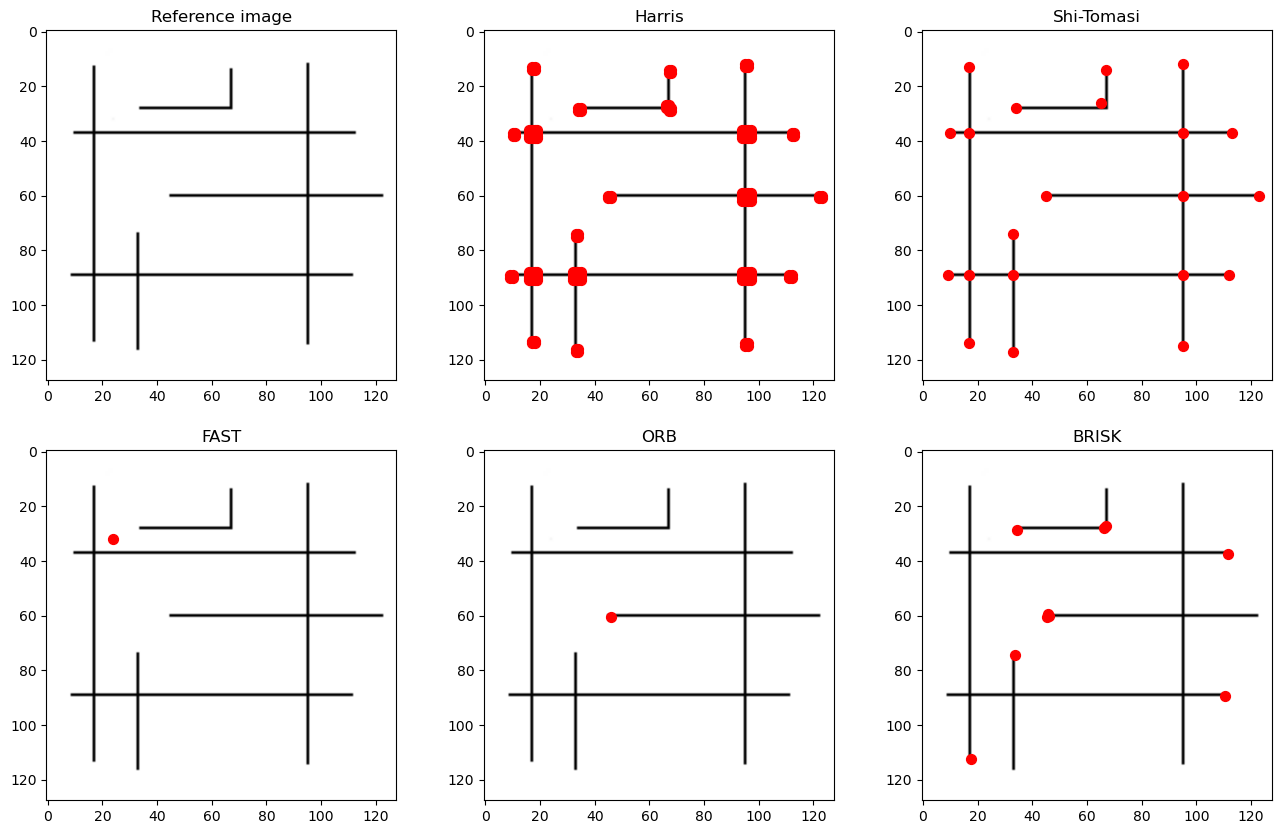

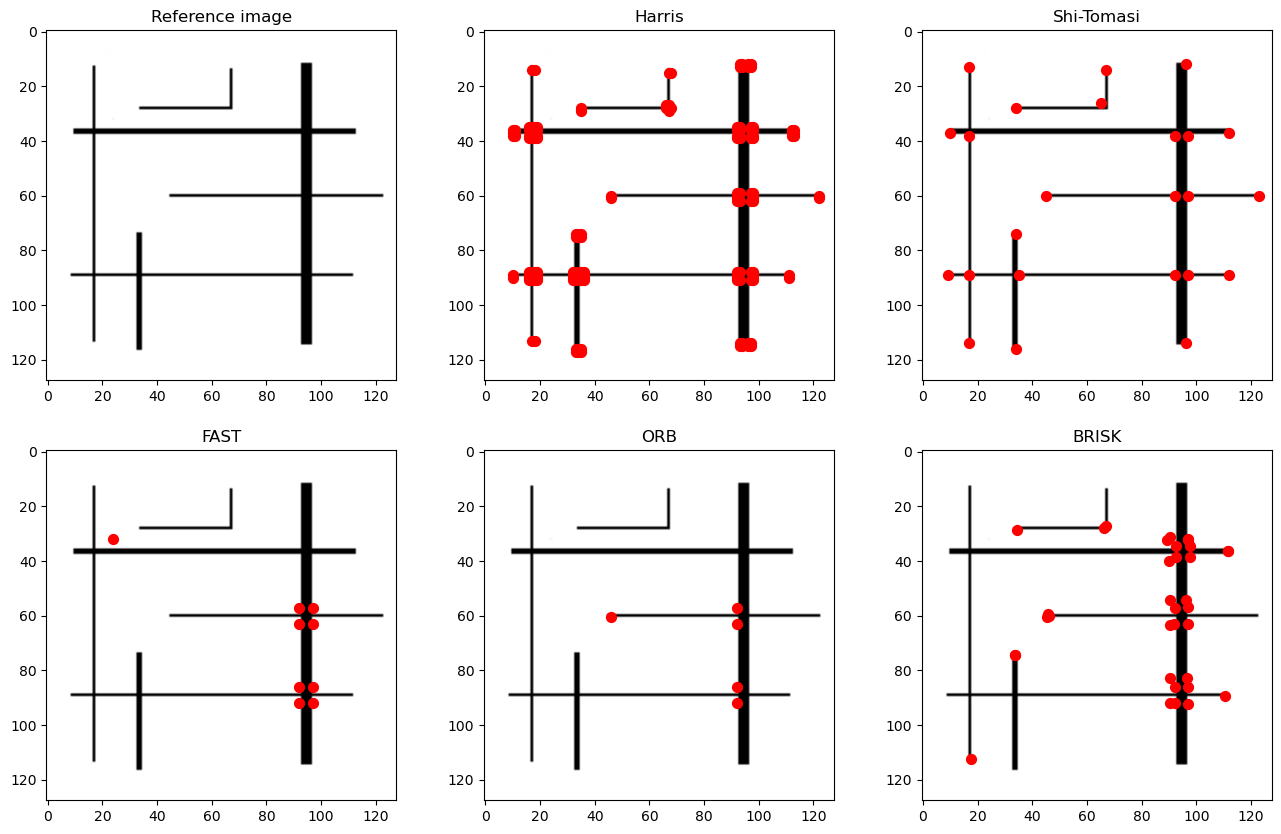

In [3]:
image = cv2.imread( 'test_1.png')
corner_1 = corner_detection(image)

image = cv2.imread( 'test_2.png')
corner_2 = corner_detection(image)

From the results. We can see that Shi-Tomasi outperforms the rest. Also, the image is better if it has uniform thickeness of 1. Otherwise, the corner detector will treat it as a box, which will make single line have four corners. 

## Part 1: Pre-processing the input image

Now that I know that the lines should be thin, then we need to apply several transformation to our real real image straight from the architectural design. Here, I started at a small scale first. I cropped several 128 by 128 patches from the original image.

The lines are actually "bungi-bungi" ofc we want it to be solid. So I tried changing the resolution, applying gaussian blur, and morphological operators (dilation, erosion).

I will also apply a padding to detected those on the edge of the image.

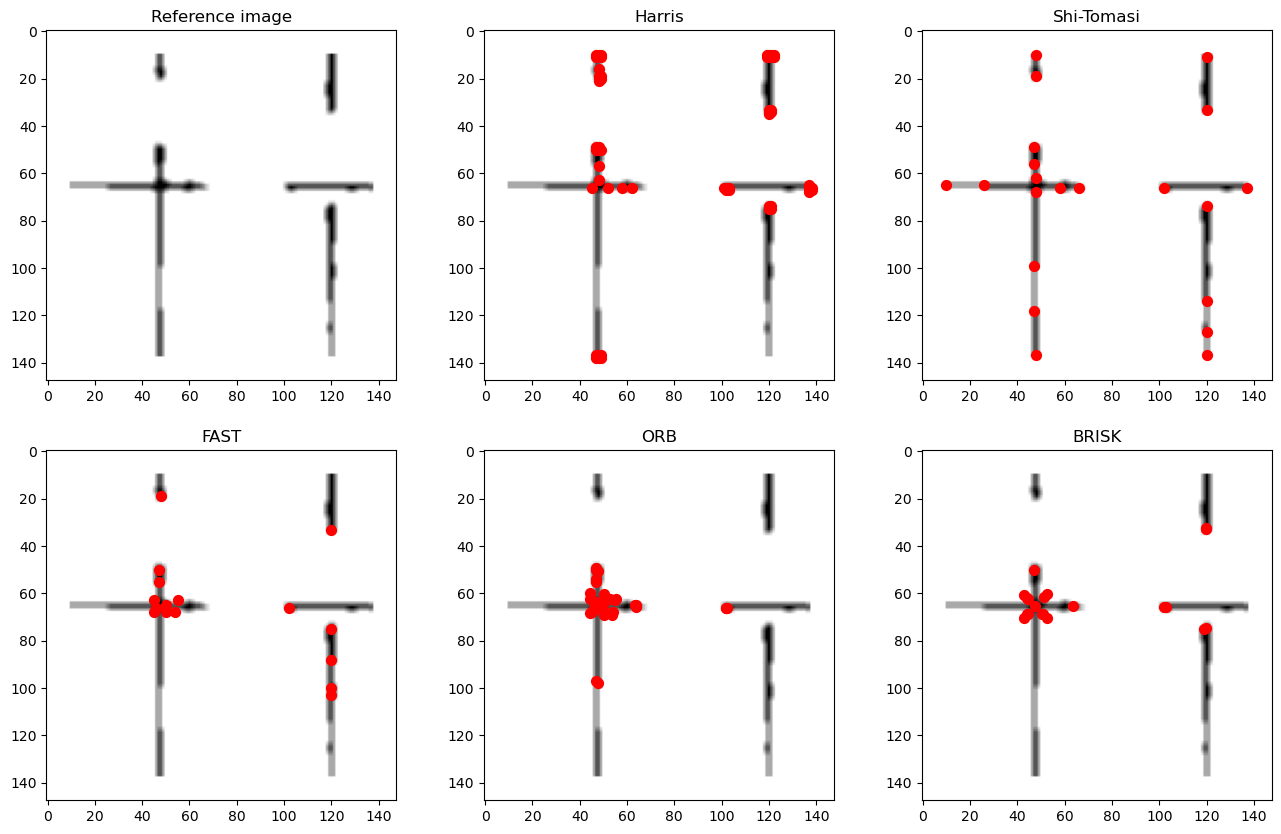

In [4]:
image = cv2.imread( 'test_3.png')

#=============================PRE PROCESSING STAGE================================#

# Trial 1: Change the resolution by resizing the image dimension. 
#image = cv2.resize(image, (16, 16)) #Original is 128 by 128. 
#_, image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
#image[image != 255] = 0

# Trial 2: Applying Gaussian blur
#image = cv2.GaussianBlur(image, (3,3), 100)

# Trial 3: Dilation and erosion
kernel = np.ones((2,2), np.uint8)
image = cv2.erode(image, kernel, iterations=2) #tinitimpla 'to'
image = cv2.dilate(image, kernel, iterations=5)

image = cv2.GaussianBlur(image, (3,3), 100)

# Add white padding to the image
image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])

corner_x = corner_detection(image)

The above configuration - 2 erodes, 3 dilates, then 3 by 3 gaussian is, by far, the best in detecting the right corners. Other trials in my presentation. In that case, I will create a `pre_pros()` function

In [5]:
def pre_pros(image, erode_iter,dilate_iter, kernel_gauss):
    kernel = np.ones((2,2), np.uint8)
    image = cv2.erode(image, kernel, iterations = erode_iter) 
    image = cv2.dilate(image, kernel, iterations= dilate_iter)
    image = cv2.GaussianBlur(image, kernel_gauss, 100)
    image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    
    return image

#image = cv2.imread( 'test_3.png')
#image_x = pre_pros(image, 2,5,(3,3))
#corner_x = corner_detection(image_x)

## Part 2: Connecting the corner coordinates

Next is to connect the corner coordinates to make a line. This is challenging since from the list of corners that we have, which pair will you connect that matches the image? In that case, what I did is for every connected corners that makes a line, I will mask this line to the original image. In that mask, I will compute for the average value of the pixels. The minimum value will be the best match line. 

Why minimum? if the drawn line matches line in the original image, then both are black. Thus, lower average intensity value. If it is not a match, then we are sure that there will be white areas which will make the score higher.

`connect_edges` will take image and corners as inputs and it will return the pairs of coordinates of the lines that matches our original image.

[((120, 137), (120, 115)), ((120, 74), (120, 34)), ((48, 129), (48, 138)), ((47, 99), (47, 92)), ((48, 11), (47, 99)), ((48, 138), (48, 129)), ((102, 82), (137, 82)), ((120, 115), (120, 137)), ((137, 82), (102, 82)), ((66, 82), (58, 82)), ((48, 86), (48, 80)), ((48, 80), (48, 86)), ((10, 83), (66, 82)), ((120, 11), (120, 74)), ((47, 92), (47, 99)), ((58, 82), (48, 86)), ((26, 83), (58, 82)), ((120, 21), (120, 74)), ((47, 30), (47, 99)), ((120, 34), (120, 74))]


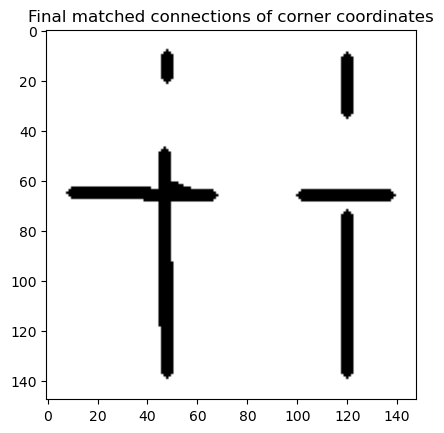

In [31]:
def connect_edges(image, corners, show_plot=True):
    corners = corners.astype(int)
    thickness = 4 # thickness of the line
    height, width = image.shape[:2]
    final = np.ones((height, width, 3), dtype=np.uint8)* 255

    line_coor = []
    for i in range(len(corners)-1):
        criteria = []
        for j in range(0,len(corners)):
            if j == i:
                crit_score = 10000000
                criteria.append(crit_score)
            else:
                
                mask = np.zeros((height, width), dtype=np.uint8)
                mask = cv2.line(mask, (corners[i][0][0], corners[i][0][1]), (corners[j][0][0], corners[j][0][1]), 255, 4, cv2.LINE_8)
                #-------------- uncomment this portion to see the masking
                result = cv2.bitwise_and(image, image, mask = mask) 
                #plt.imshow(result)
                #plt.show()
                #--------------
                roi = image[mask > 0]

                sum_pix = np.sum(roi) #sum of pixel intensities in ROI
                num_pixels = np.sum(mask) # number of pixels in the ROI
                crit_score = sum_pix / num_pixels # average pixel value in the ROI
                #print(crit_score)
                criteria.append(crit_score)
                #print("score:", crit_score)
        max_index = np.argmin(criteria)
        #print("max_index = ",max_index)
        final = cv2.line(final, (corners[i][0][0], corners[i][0][1]), 
                     (corners[max_index][0][0], corners[max_index][0][1]), (0, 0, 0), thickness, cv2.LINE_8)
        coor = (corners[i][0][0], 148-corners[i][0][1]),(corners[max_index][0][0], 148-corners[max_index][0][1]) #minus 144 kasi pagbasa sa next step ay from bottom
        line_coor.append(coor)
    if show_plot:
        plt.imshow(final)
        plt.title("Final matched connections of corner coordinates")
    #print(line_coor)
    return line_coor

image = cv2.imread( 'test_3.png')
image = pre_pros(image, 2,5,(3,3))
corners = corner_detection(image, show_plot = False)
line_coor = connect_edges(image,corners)
print(line_coor)

## Part 3: Creating a vector given the matched corner coordinates of the lines

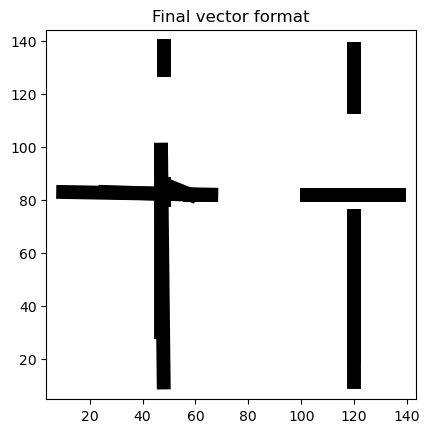

In [34]:
def create_vectorlines(lines, save_path, line_thickness, file_format='pdf', show_plot = True):
    fig, ax = plt.subplots()
    for line in lines:
        start_point, end_point = line
        ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='black', linewidth=line_thickness)
    # Set aspect ratio to be equal
    ax.set_aspect('equal')
    # Save the figure
    if file_format.lower() == 'pdf':
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    elif file_format.lower() == 'svg':
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    else:
        print("Unsupported file format. Please choose 'pdf' or 'svg'. ONLYY")
    if show_plot:
        plt.title("Final vector format")
        plt.show()

create_vectorlines(line_coor, 'vector_test3.svg', line_thickness=10, file_format='svg')

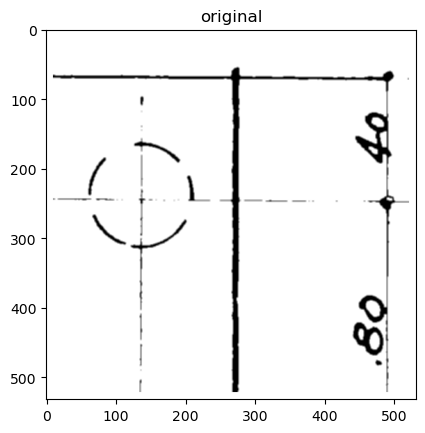

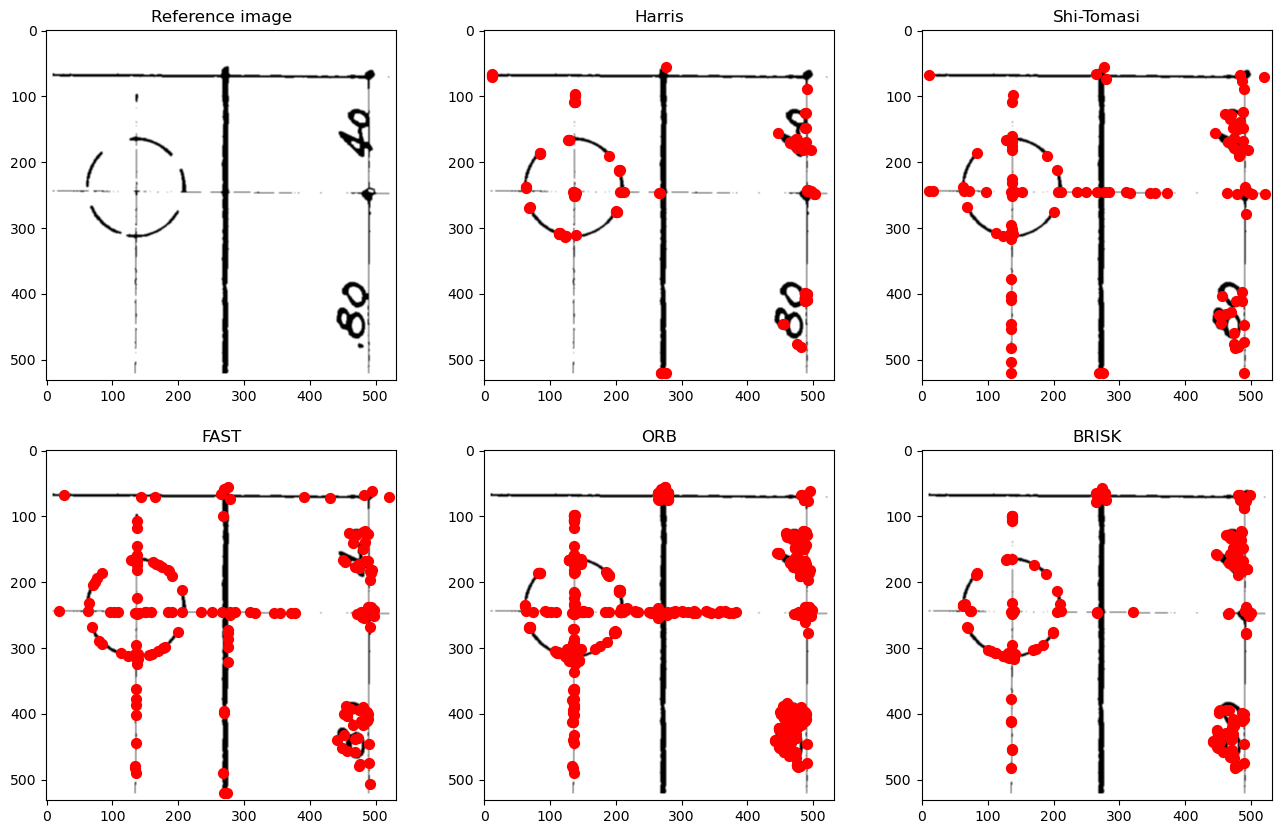

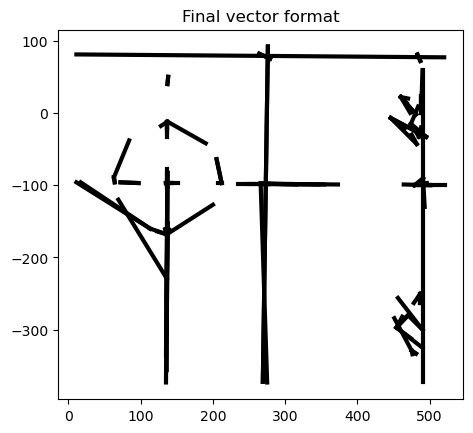

In [50]:
#To summarize:
image = cv2.imread( 'test_10.png')
image = pre_pros(image, 2,3,(3,3))
plt.imshow(image), plt.title("original")
plt.show
corners = corner_detection(image, show_plot = True)
line_coor = connect_edges(image,corners, show_plot = False)
create_vectorlines(line_coor, 'vector_test10a.pdf', line_thickness=3, file_format='pdf')